In [10]:
pip install nltk

In [11]:
pip install transformers

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from tqdm import tqdm
import torchtext
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from transformers import DistilBertModel, DistilBertTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import transformers as ppb

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
data = pd.read_csv('/content/data.csv')
data.shape

(6420, 3)

In [14]:
data.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


Проверим данные на пропуски

In [15]:
data.isnull().sum()

id       0
tweet    0
label    0
dtype: int64

In [16]:
data['label'].value_counts()

real    3360
fake    3060
Name: label, dtype: int64

Дисбаланса классов не наблюдается.

(array([3360.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3060.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

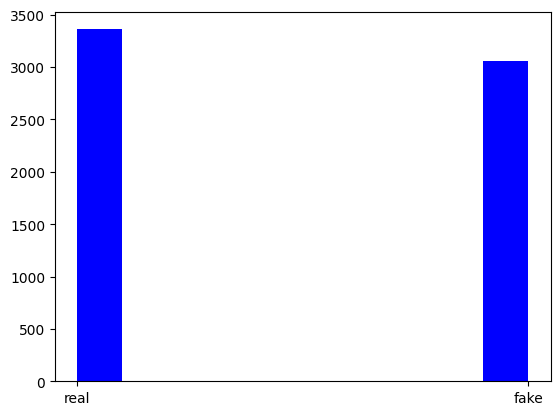

In [17]:
plt.hist(data['label'], color = 'blue')

In [18]:
DataFrame = []
vectorizers = ['CountVectorizer', 'Tf-Idf']
models = ['LogisticRegression', 'GaussianNB']

In [21]:
def dummy(text):
   return text

def classification_report_and_ConfusionMatrix(vectorizer, normalization, model, Y_test, X_test_prediction):
  print('\n', vectorizer, normalization, model)
  print(classification_report(Y_test, X_test_prediction))
  print('\n')
  ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_test, X_test_prediction)).plot()
  plt.show()


def results_with_different_vectorization_and_models(dataset, normalization):
  for vectorizer in vectorizers:

    if vectorizer == 'CountVectorizer':

        vectorizer_CountVector = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_df=0.5, min_df=25, max_features=1000, stop_words = 'english', dtype=np.int16)
        X_CountVector = vectorizer_CountVector.fit_transform(dataset['tweet'])
        df_CountVector = pd.DataFrame(X_CountVector.toarray())
        df_CountVector.columns = vectorizer_CountVector.get_feature_names_out()
        Y = dataset['label'].values
        X_train, X_test, Y_train, Y_test = train_test_split(X_CountVector, Y, test_size=0.2, stratify=Y, random_state=2)
    elif vectorizer == 'Tf-Idf':

        X = dataset['tweet'].values
        Y = dataset['label'].values
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)
        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)

    for model in models:
      if model == 'GaussianNB':

        X_train_dense = X_train.toarray()
        model_GaussianNB = GaussianNB()
        result_bayes = model_GaussianNB.fit(X_train_dense, Y_train)

        X_train_prediction_nb = model_GaussianNB.predict(X_train.toarray())
        training_data_accuracy_nb = accuracy_score(Y_train, X_train_prediction_nb)

        X_test_prediction_nb = model_GaussianNB.predict(X_test.toarray())
        test_data_accuracy_nb = accuracy_score(Y_test, X_test_prediction_nb)

        df = [vectorizer, normalization, model, training_data_accuracy_nb, test_data_accuracy_nb]
        DataFrame.append(df)

        classification_report_and_ConfusionMatrix(vectorizer, normalization, model, Y_test, X_test_prediction_nb)

      elif model == 'LogisticRegression':

        model_LogisticRegression = LogisticRegression(max_iter=1000)
        model_LogisticRegression.fit(X_train, Y_train)

        X_train_prediction_lr = model_LogisticRegression.predict(X_train)
        training_data_accuracy_lr = accuracy_score(Y_train, X_train_prediction_lr)

        X_test_prediction_lr = model_LogisticRegression.predict(X_test)
        test_data_accuracy_lr = accuracy_score(Y_test, X_test_prediction_lr)

        df = [vectorizer, normalization, model, training_data_accuracy_lr, test_data_accuracy_lr]
        DataFrame.append(df)

        classification_report_and_ConfusionMatrix(vectorizer, normalization, model, Y_test, X_test_prediction_lr)



In [22]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)

  return stemmed_content

port_stem = PorterStemmer()
data_st = data.copy()
data_st['tweet'] = data['tweet'].apply(stemming)
data_st.head()

data_st.to_csv('data_st.csv')


In [26]:
lemmatizer = WordNetLemmatizer()
data_lemmatizer = data.copy()

for i in range(data.shape[0]):
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in data["tweet"][i]]
    data_lemmatizer["tweet"][i] = lemmatized_tokens

data_lemmatizer.to_csv('data_lemmatizer.csv')


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(



 CountVectorizer Без обработки LogisticRegression
              precision    recall  f1-score   support

        fake       0.80      0.86      0.83       612
        real       0.86      0.81      0.83       672

    accuracy                           0.83      1284
   macro avg       0.83      0.83      0.83      1284
weighted avg       0.83      0.83      0.83      1284





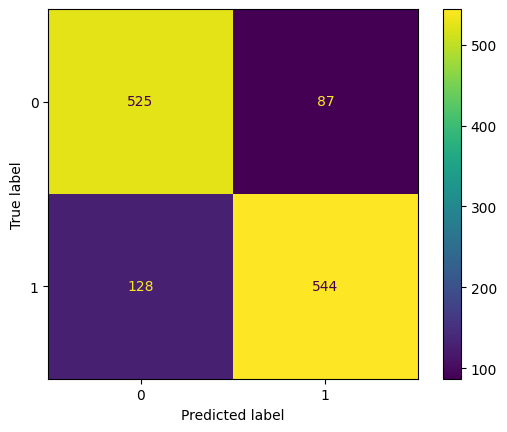


 CountVectorizer Без обработки GaussianNB
              precision    recall  f1-score   support

        fake       0.59      0.98      0.73       612
        real       0.96      0.37      0.53       672

    accuracy                           0.66      1284
   macro avg       0.77      0.68      0.63      1284
weighted avg       0.78      0.66      0.63      1284





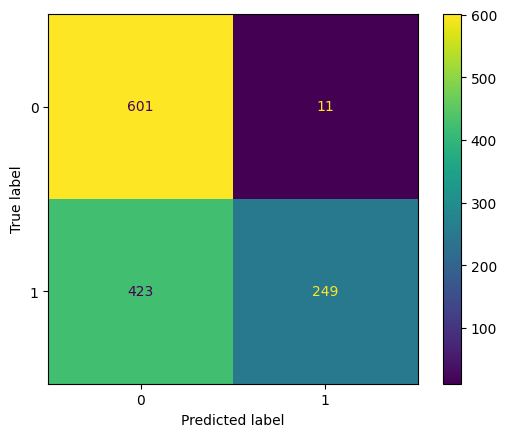


 TfidfVectorizer() Без обработки LogisticRegression
              precision    recall  f1-score   support

        fake       0.92      0.92      0.92       612
        real       0.92      0.92      0.92       672

    accuracy                           0.92      1284
   macro avg       0.92      0.92      0.92      1284
weighted avg       0.92      0.92      0.92      1284





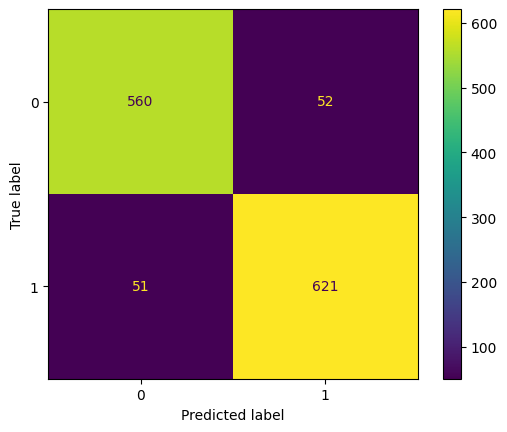


 TfidfVectorizer() Без обработки GaussianNB
              precision    recall  f1-score   support

        fake       0.85      0.88      0.86       612
        real       0.89      0.86      0.87       672

    accuracy                           0.87      1284
   macro avg       0.87      0.87      0.87      1284
weighted avg       0.87      0.87      0.87      1284





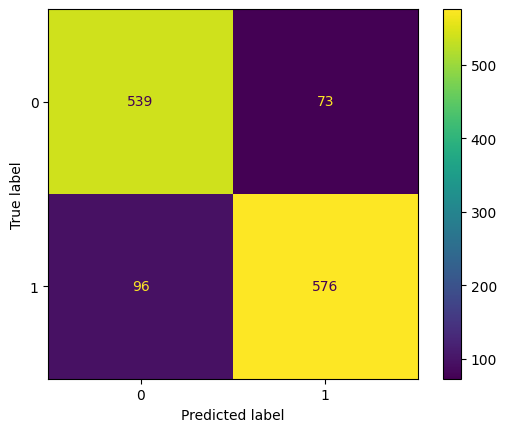

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(



 CountVectorizer Stemming LogisticRegression
              precision    recall  f1-score   support

        fake       0.60      0.68      0.64       612
        real       0.67      0.59      0.63       672

    accuracy                           0.63      1284
   macro avg       0.63      0.63      0.63      1284
weighted avg       0.63      0.63      0.63      1284





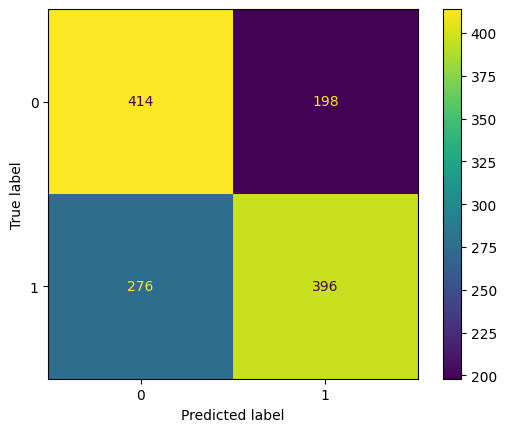


 CountVectorizer Stemming GaussianNB
              precision    recall  f1-score   support

        fake       0.59      0.76      0.66       612
        real       0.70      0.51      0.59       672

    accuracy                           0.63      1284
   macro avg       0.64      0.64      0.63      1284
weighted avg       0.65      0.63      0.62      1284





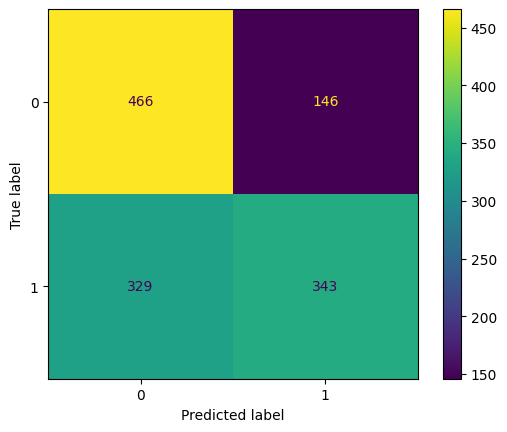


 TfidfVectorizer() Stemming LogisticRegression
              precision    recall  f1-score   support

        fake       0.92      0.90      0.91       612
        real       0.91      0.93      0.92       672

    accuracy                           0.92      1284
   macro avg       0.92      0.92      0.92      1284
weighted avg       0.92      0.92      0.92      1284





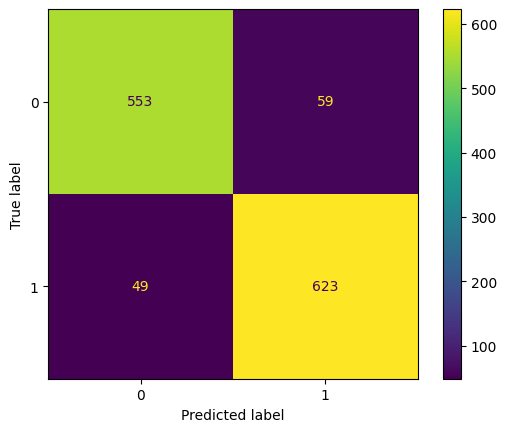


 TfidfVectorizer() Stemming GaussianNB
              precision    recall  f1-score   support

        fake       0.89      0.84      0.86       612
        real       0.86      0.90      0.88       672

    accuracy                           0.87      1284
   macro avg       0.87      0.87      0.87      1284
weighted avg       0.87      0.87      0.87      1284





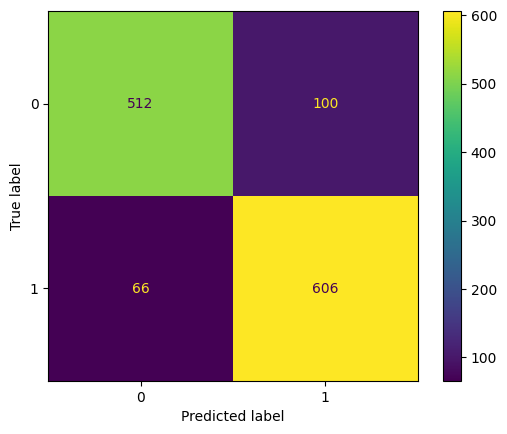

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(



 CountVectorizer Lemmatization LogisticRegression
              precision    recall  f1-score   support

        fake       0.60      0.68      0.64       612
        real       0.67      0.59      0.63       672

    accuracy                           0.63      1284
   macro avg       0.63      0.63      0.63      1284
weighted avg       0.63      0.63      0.63      1284





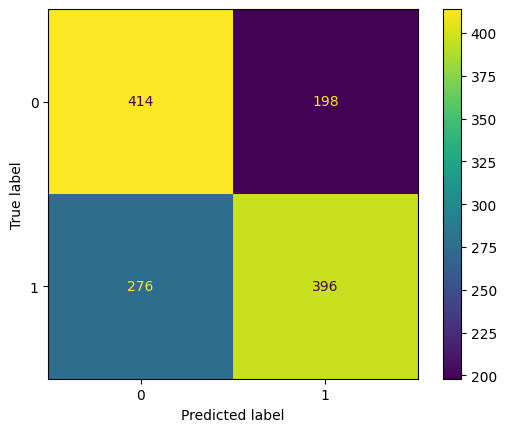


 CountVectorizer Lemmatization GaussianNB
              precision    recall  f1-score   support

        fake       0.59      0.76      0.66       612
        real       0.70      0.51      0.59       672

    accuracy                           0.63      1284
   macro avg       0.64      0.64      0.63      1284
weighted avg       0.65      0.63      0.62      1284





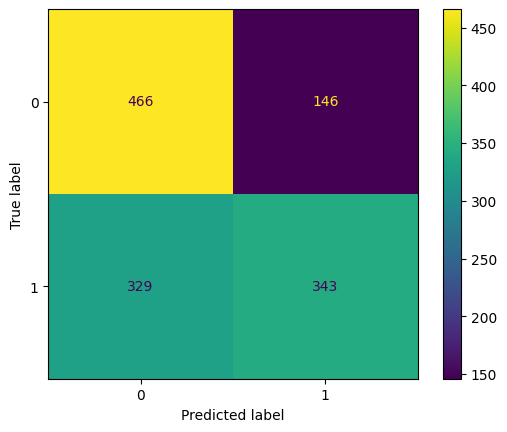


 TfidfVectorizer() Lemmatization LogisticRegression
              precision    recall  f1-score   support

        fake       0.92      0.90      0.91       612
        real       0.91      0.93      0.92       672

    accuracy                           0.92      1284
   macro avg       0.92      0.92      0.92      1284
weighted avg       0.92      0.92      0.92      1284





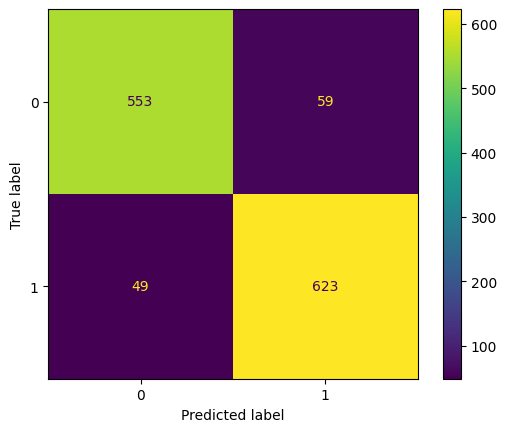


 TfidfVectorizer() Lemmatization GaussianNB
              precision    recall  f1-score   support

        fake       0.89      0.84      0.86       612
        real       0.86      0.90      0.88       672

    accuracy                           0.87      1284
   macro avg       0.87      0.87      0.87      1284
weighted avg       0.87      0.87      0.87      1284





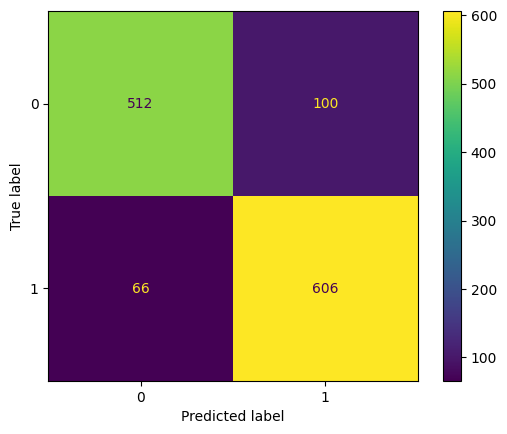

In [27]:
results_with_different_vectorization_and_models(data, 'Без обработки')
results_with_different_vectorization_and_models(data_st, 'Stemming')
results_with_different_vectorization_and_models(data_st, 'Lemmatization')

In [28]:
Result = pd.DataFrame(DataFrame, columns=['Vectorizer', 'processing method', 'model', 'accuracy of training data ', 'accuracy of test data'])

In [29]:
Result.sort_values(['accuracy of training data ', 'accuracy of test data'], ascending=[False, False])

,Vectorizer,processing method,model,accuracy of training data,accuracy of test data
3,TfidfVectorizer(),Без обработки,GaussianNB,0.999026,0.868380
11,TfidfVectorizer(),Без обработки,GaussianNB,0.999026,0.868380
7,TfidfVectorizer(),Stemming,GaussianNB,0.991433,0.870717
15,TfidfVectorizer(),Stemming,GaussianNB,0.991433,0.870717
19,TfidfVectorizer(),Lemmatization,GaussianNB,0.991433,0.870717
6,TfidfVectorizer(),Stemming,LogisticRegression,0.965537,0.915888
14,TfidfVectorizer(),Stemming,LogisticRegression,0.965537,0.915888
18,TfidfVectorizer(),Lemmatization,LogisticRegression,0.965537,0.915888
2,TfidfVectorizer(),Без обработки,LogisticRegression,0.964369,0.919782
10,TfidfVectorizer(),Без обработки,LogisticRegression,0.964369,0.919782
